In [1]:
import os
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
from scipy.spatial.transform import Rotation as R
from shapely.geometry import Point
from pyproj import Transformer

from asp_plot.jitter import read_linescan_csm_cam, read_angles

In [2]:
before1 = "../tests/test_data/jitter/csm-10300100A0D00200.r100.adjusted_state.json"
before2 = "../tests/test_data/jitter/csm-10300100A15E3900.r100.adjusted_state.json"
after1 = "../tests/test_data/jitter/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"
after2 = "../tests/test_data/jitter/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"

utm_zone = "32604"

In [3]:
# cam1, cam2 = before1, after1
cam1, cam2 = before2, after2

positions1, rotations1 = read_linescan_csm_cam(cam1)
positions2, rotations2 = read_linescan_csm_cam(cam2)

positions1 = np.array(positions1)
positions2 = np.array(positions2)
rotations1 = np.array(rotations1)
rotations2 = np.array(rotations2)

orig_rotation_angles, opt_rotation_angles = read_angles([cam1], [cam2], [])

orig_roll  = [r[0] for r in orig_rotation_angles]
orig_pitch = [r[1] for r in orig_rotation_angles]
orig_yaw   = [r[2] for r in orig_rotation_angles]
opt_roll   = [r[0] for r in opt_rotation_angles]
opt_pitch  = [r[1] for r in opt_rotation_angles]
opt_yaw    = [r[2] for r in opt_rotation_angles]

roll_diff = np.array(orig_roll) - np.array(opt_roll)
pitch_diff = np.array(orig_pitch) - np.array(opt_pitch)
yaw_diff = np.array(orig_yaw) - np.array(opt_yaw)

In [4]:
def ecef_to_wgs84(positions):
    transformer = Transformer.from_crs("EPSG:4978", "EPSG:4326")
    lons, lats, alts = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((lons, lats, alts))

def ecef_to_utm(positions, utm_zone=32604):
    transformer = Transformer.from_crs("EPSG:4978", f"EPSG:{utm_zone}")
    lons, lats, alts = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((lons, lats, alts))

In [5]:
positions1_wgs84 = ecef_to_utm(positions1, utm_zone=utm_zone)
positions2_wgs84 = ecef_to_utm(positions2, utm_zone=utm_zone)

position_diffs = positions2 - positions1
x_diff = position_diffs[:, 0]
y_diff = position_diffs[:, 1]
z_diff = position_diffs[:, 2]
position_diff_magnitudes = np.linalg.norm(position_diffs, axis=1)

data = {
    'position1': [Point(x, y, z) for x, y, z in positions1_wgs84],
    'position2': [Point(x, y, z) for x, y, z in positions2_wgs84],
    'rotation1': [r for r in rotations1],
    'rotation2': [r for r in rotations2],
    'position_diff_magnitude': position_diff_magnitudes,
    'x_diff': x_diff,
    'y_diff': y_diff,
    'z_diff': z_diff,
    'roll_diff': roll_diff,
    'pitch_diff': pitch_diff,
    'yaw_diff': yaw_diff,
}

df = pd.DataFrame(data)

gdf = gpd.GeoDataFrame(df, geometry='position1')

gdf.set_crs(epsg=utm_zone, inplace=True)

gdf_position2 = gpd.GeoDataFrame(df, geometry='position2')

gdf_position2.set_crs(epsg=utm_zone, inplace=True)


,position1,position2,rotation1,rotation2,position_diff_magnitude,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff
0,POINT Z (1096569.286596078 -10883627.680715237...,POINT Z (1096569.287 -10883627.681 795131.635),"[[-0.16241692496906107, 0.9295643588459488, 0....","[[-0.16241692496906107, 0.9295643588459488, 0....",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,POINT Z (1096632.1492305566 -10883508.76866168...,POINT Z (1096632.149 -10883508.769 795131.685),"[[-0.16244050759520745, 0.9296102059963607, 0....","[[-0.16244050759520745, 0.9296102059963607, 0....",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,POINT Z (1096695.011373337 -10883389.856211198...,POINT Z (1096695.011 -10883389.856 795131.735),"[[-0.16246408306115367, 0.9296560244668811, 0....","[[-0.16246408306115367, 0.9296560244668811, 0....",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,POINT Z (1096757.8730243142 -10883270.94336393...,POINT Z (1096757.873 -10883270.943 795131.785),"[[-0.1624876514360345, 0.9297018142593526, 0.3...","[[-0.1624876514360345, 0.9297018142593527, 0.3...",0.000000e+00,0.0,0.0,0.000000e+00,-5.684342e-14,-1.065814e-14,-3.552714e-14
4,POINT Z (1096820.7341835124 -10883152.03011977...,POINT Z (1096820.734 -10883152.03 795131.835),"[[-0.16251121272802505, 0.9297475753872376, 0....","[[-0.16251121272802505, 0.9297475753872377, 0....",0.000000e+00,0.0,0.0,0.000000e+00,-4.973799e-14,0.000000e+00,-2.842171e-14
...,...,...,...,...,...,...,...,...,...,...,...
1726,POINT Z (1204322.0290080842 -10677776.99356448...,POINT Z (1204322.029 -10677776.994 795190.519),"[[-0.18409818941399647, 0.9775094528036894, 0....","[[-0.18409818941399647, 0.9775094528036893, 0....",9.313226e-10,0.0,0.0,-9.313226e-10,-2.886580e-14,2.486900e-14,-7.105427e-15
1727,POINT Z (1204384.0144884523 -10677657.36578639...,POINT Z (1204384.014 -10677657.366 795190.537),"[[-0.1840968411862951, 0.9775233690850222, 0.1...","[[-0.1840968411862951, 0.9775233690850222, 0.1...",0.000000e+00,0.0,0.0,0.000000e+00,1.374989e-11,-1.738982e-10,3.558398e-11
1728,POINT Z (1204445.9994432358 -10677537.73757604...,POINT Z (1204445.999 -10677537.738 795190.555),"[[-0.1840954733346516, 0.9775372720848355, 0.1...","[[-0.1840954733346516, 0.9775372720848355, 0.1...",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1729,POINT Z (1204507.983872468 -10677418.108933348...,POINT Z (1204507.984 -10677418.109 795190.574),"[[-0.18409408590980025, 0.9775511617915903, 0....","[[-0.18409408590980048, 0.9775511617915903, 0....",0.000000e+00,0.0,0.0,0.000000e+00,3.197442e-14,-4.973799e-14,2.131628e-14


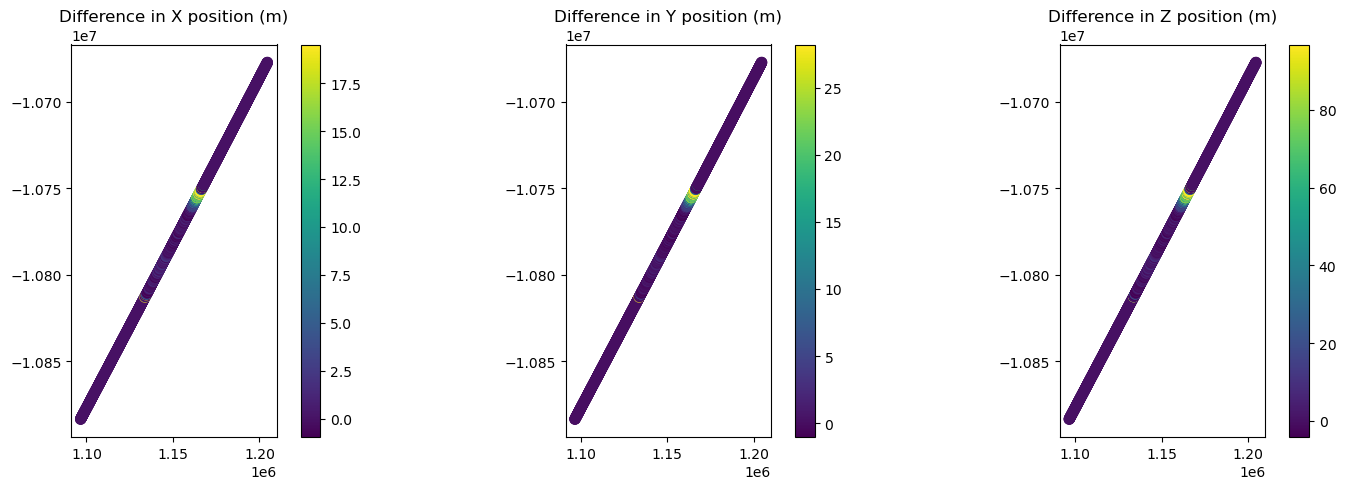

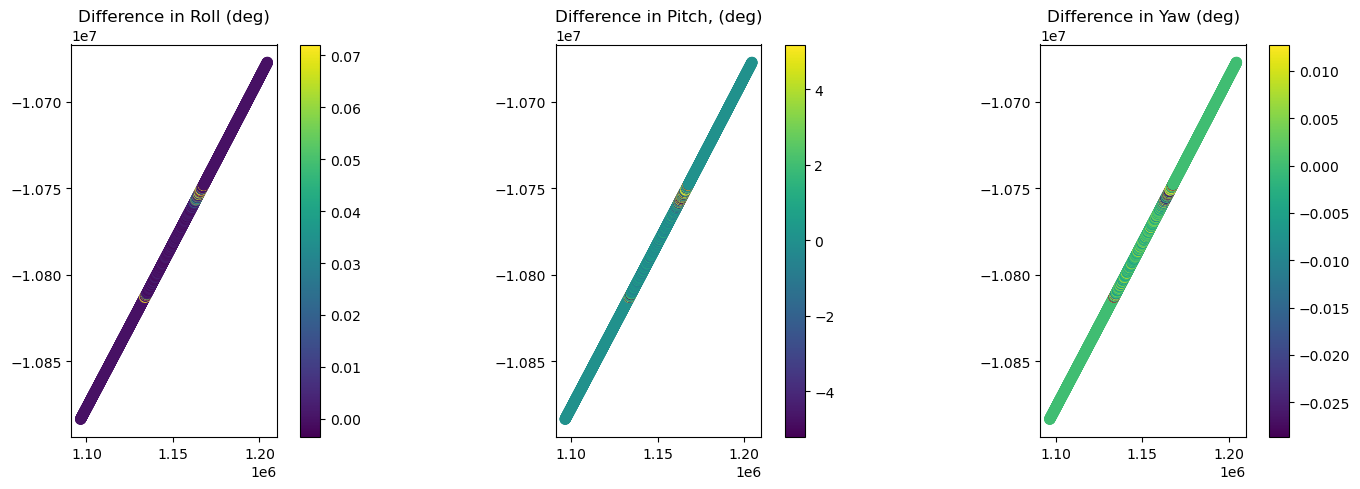

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(column='x_diff', cmap='viridis', markersize=50, legend=True, ax=axes[0], vmin=np.percentile(x_diff, 1), vmax=np.percentile(x_diff, 99))
axes[0].set_title('Difference in X position (m)')

gdf.plot(column='y_diff', cmap='viridis', markersize=50, legend=True, ax=axes[1], vmin=np.percentile(y_diff, 1), vmax=np.percentile(y_diff, 99))
axes[1].set_title('Difference in Y position (m)')

gdf.plot(column='z_diff', cmap='viridis', markersize=50, legend=True, ax=axes[2], vmin=np.percentile(z_diff, 1), vmax=np.percentile(z_diff, 99))
axes[2].set_title('Difference in Z position (m)')

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(column='roll_diff', cmap='viridis', markersize=50, legend=True, ax=axes[0], vmin=np.percentile(roll_diff, 1), vmax=np.percentile(roll_diff, 99))
axes[0].set_title('Difference in Roll (deg)')

gdf.plot(column='pitch_diff', cmap='viridis', markersize=50, legend=True, ax=axes[1], vmin=np.percentile(pitch_diff, 1), vmax=np.percentile(pitch_diff, 99))
axes[1].set_title('Difference in Pitch, (deg)')

gdf.plot(column='yaw_diff', cmap='viridis', markersize=50, legend=True, ax=axes[2], vmin=np.percentile(yaw_diff, 1), vmax=np.percentile(yaw_diff, 99))
axes[2].set_title('Difference in Yaw (deg)')

plt.tight_layout()
plt.show()

<Axes: >

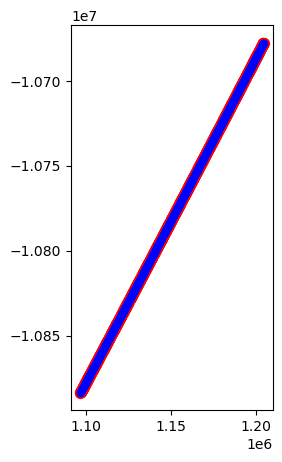

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

gdf.plot(ax=ax, color='red', markersize=50)
gdf_position2.plot(ax=ax, color='blue', markersize=20)

<Axes: >

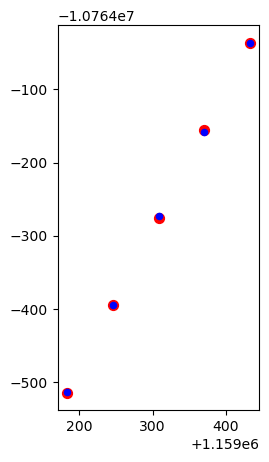

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

gdf.iloc[1000:1005].plot(ax=ax, color='red', markersize=50)
gdf_position2.iloc[1000:1005].plot(ax=ax, color='blue', markersize=20)